In [1]:
import torch
import torch.nn as nn
import numpy as np
from pyDOE import lhs
import matplotlib.pyplot as plt
from matplotlib.animation import PillowWriter
import matplotlib.animation as animation

The 1D viscous Burgers' equation (also known as the Burgers' heat equation) is given by:

$$
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}
$$

where:
- $ u(x, t) $ is the solution,
- $ x \in [-1, 1] $ is the spatial domain,
- $ t \in [0, 1] $ is the time domain,
- $ \nu = (0.01/\pi) $ is the viscosity coefficient.

**Dirichlet boundary conditions:**
$
u(-1, t) = 0, \quad u(1, t) = 0, \quad t \in [0, 1]
$

**Initial condition:**
$
u(x, 0) = -\sin(\pi x), \quad x \in [-1, 1]
$

In [2]:
# Physics-Informed Neural Network (PINN) for Heat Equation
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 1)
        )

    def forward(self, x, t):
        return self.net(torch.cat([x, t], dim=1))

Residual of the PDE given by:
$$f := \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} - \nu \frac{\partial^2 u}{\partial x^2}$$

where $u(x,t)$ is approximated by the neural network $\tilde{u}(x,t)$. 

In [3]:
# residual function for the PDE
def pde_residual(model, x, t, nu):
    x.requires_grad = True
    t.requires_grad = True
    u = model(x, t)
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u), create_graph=True)[0]
    return u_t + u * u_x - nu * u_xx

In [4]:
# Training data
N_f, N_u = 10000, 1000
lhs_samples = lhs(2, samples=N_f)
x_f = torch.tensor(2 * lhs_samples[:, 0:1] - 1, dtype=torch.float32)
t_f = torch.tensor(lhs_samples[:, 1:2], dtype=torch.float32)
x_u = torch.linspace(-1, 1, N_u).view(-1, 1)
t_u = torch.zeros_like(x_u)
u_u = -torch.sin(np.pi * x_u)

# Add boundary points (x = -1 and x = 1) at all times
t_b = torch.linspace(0, 1, N_u).view(-1, 1)
x_lb = -torch.ones_like(t_b)
x_ub = torch.ones_like(t_b)
u_b = torch.zeros_like(t_b)

# Model and optimizer
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
nu = 0.01 / np.pi

$$
\mathcal{L} = \mathcal{L}_f + \mathcal{L}_u
$$
where:
- $ \mathcal{L}_f = \frac{1}{N_f} \sum_{i=1}^{N_f}|f(t^{i}_{f}, x^{i}_{f})|^2$ is the physics loss
- $ \mathcal{L}_u $ is the initial and boundary conditions loss

In [5]:
# Training loop
for epoch in range(5000):
    optimizer.zero_grad()
    loss_f = torch.mean(pde_residual(model, x_f, t_f, nu)**2)
    loss_u = torch.mean((model(x_u, t_u) - u_u)**2 + (model(x_lb, t_b) - u_b)**2 + ((model(x_ub, t_b) - u_b)**2))
    loss = loss_f + loss_u
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.5f}")

Epoch 0, Loss: 0.51425
Epoch 100, Loss: 0.25483
Epoch 200, Loss: 0.15014
Epoch 300, Loss: 0.13167
Epoch 400, Loss: 0.11736
Epoch 500, Loss: 0.10563
Epoch 600, Loss: 0.09922
Epoch 700, Loss: 0.09617
Epoch 800, Loss: 0.09150
Epoch 900, Loss: 0.08476
Epoch 1000, Loss: 0.07898
Epoch 1100, Loss: 0.04952
Epoch 1200, Loss: 0.03732
Epoch 1300, Loss: 0.03062
Epoch 1400, Loss: 0.02617
Epoch 1500, Loss: 0.02226
Epoch 1600, Loss: 0.01870
Epoch 1700, Loss: 0.01560
Epoch 1800, Loss: 0.01391
Epoch 1900, Loss: 0.01360
Epoch 2000, Loss: 0.01235
Epoch 2100, Loss: 0.01051
Epoch 2200, Loss: 0.01002
Epoch 2300, Loss: 0.01021
Epoch 2400, Loss: 0.03005
Epoch 2500, Loss: 0.00917
Epoch 2600, Loss: 0.00795
Epoch 2700, Loss: 0.00731
Epoch 2800, Loss: 0.00679
Epoch 2900, Loss: 0.00610
Epoch 3000, Loss: 0.00560
Epoch 3100, Loss: 0.00749
Epoch 3200, Loss: 0.00486
Epoch 3300, Loss: 0.00584
Epoch 3400, Loss: 0.00429
Epoch 3500, Loss: 0.00414
Epoch 3600, Loss: 0.00722
Epoch 3700, Loss: 0.00366
Epoch 3800, Loss: 0.0035

In [6]:
# Visualize Setup
x_test = torch.linspace(-1, 1, 200).view(-1, 1)
t_test = torch.linspace(0, 1, 100).view(-1, 1)
X, T = torch.meshgrid(x_test.squeeze(), t_test.squeeze(), indexing='ij')
u_pred = model(X.reshape(-1, 1), T.reshape(-1, 1)).detach().numpy().reshape(200, 100)

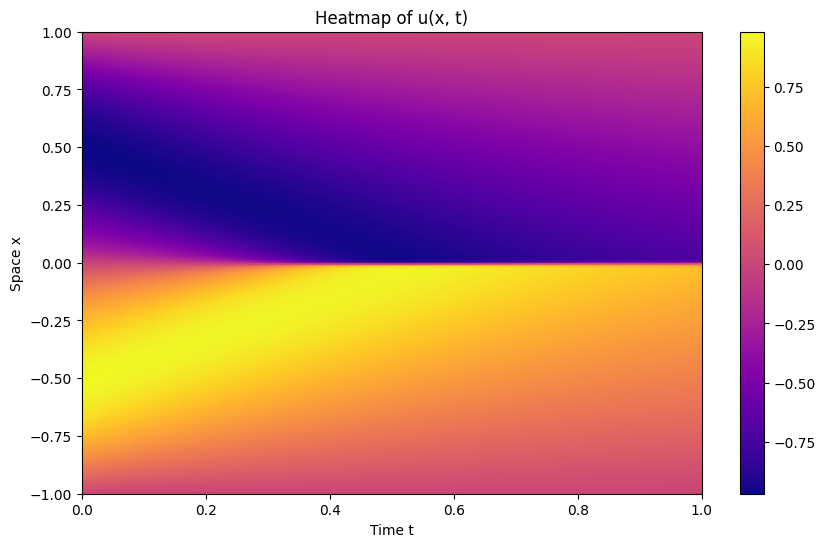

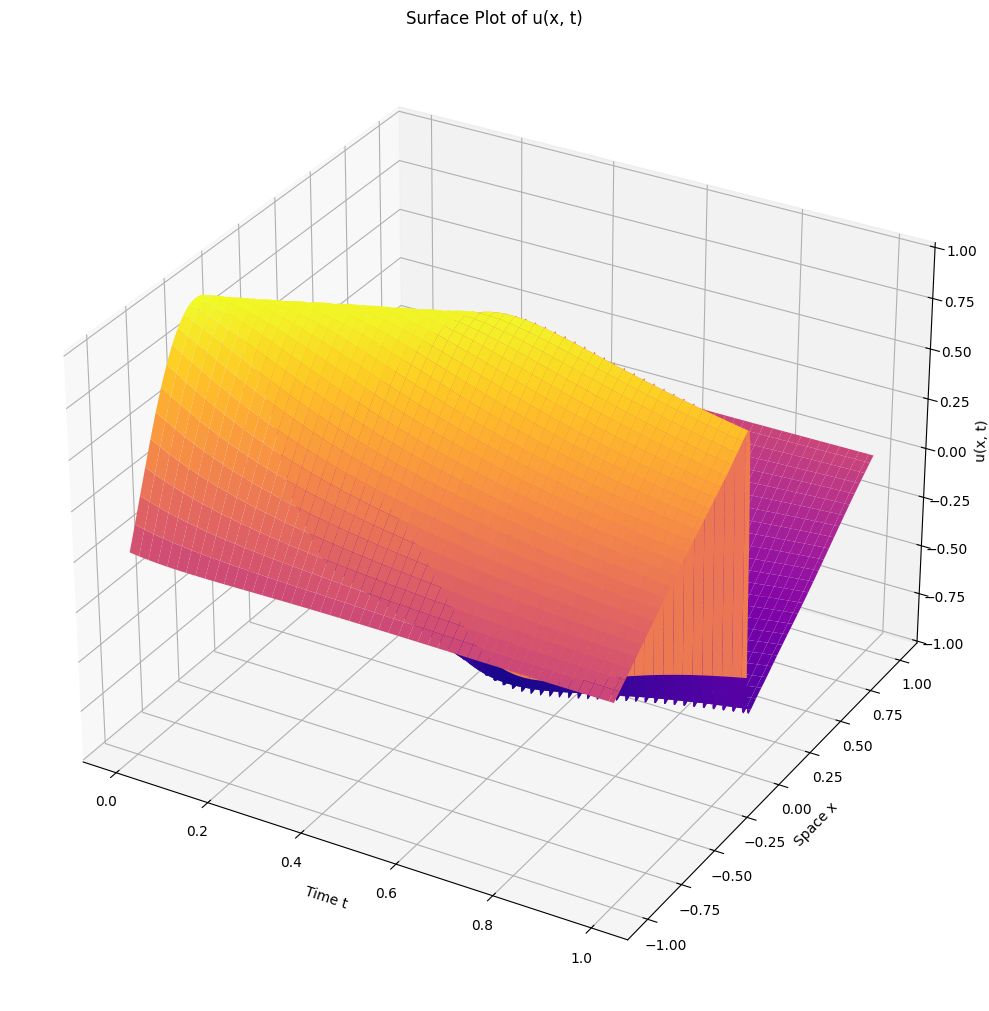

In [15]:
# 1. Heatmap (2D)
plt.figure(figsize=(10, 6))
plt.imshow(u_pred, extent=[0, 1, -1, 1], aspect='auto', origin='lower', cmap='plasma')
plt.colorbar()
plt.xlabel('Time t')
plt.ylabel('Space x')
plt.title('Heatmap of u(x, t)')
plt.show()

# 2. Surface Plot (3D)
fig = plt.figure(figsize=(10, 10), constrained_layout=True)
ax = fig.add_subplot(111, projection='3d')
X, T = np.meshgrid(np.linspace(-1, 1, 200), np.linspace(0, 1, 100))
ax.plot_surface(T, X, u_pred.T, cmap='plasma', edgecolor='none')
ax.set_xlabel('Time t')
ax.set_ylabel('Space x');'./l,//l,,lľ'
ax.set_zlabel('u(x, t)')
ax.set_title('Surface Plot of u(x, t)')
plt.show()


In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
line, = ax.plot([], [], lw=2)
ax.set_xlim(-1, 1)
ax.set_ylim(np.min(u_pred), np.max(u_pred))
ax.set_xlabel('Space x')
ax.set_ylabel('u(x, t)')
ax.set_title('Evolution of u(x, t) Over Time')

def update(frame):
    line.set_data(np.linspace(-1, 1, u_pred.shape[0]), u_pred[:, frame])
    ax.set_title(f"u(x, t) at t = {frame / u_pred.shape[1]:.2f}")
    return line,

anim = animation.FuncAnimation(fig, update, frames=u_pred.shape[1], interval=100)

# Save using PillowWriter

anim.save('u_xt_evolution.gif', writer=PillowWriter(fps=10))

plt.close()

In [7]:
N_t = u_pred.shape[1]
idx_025 = int(0.25 * N_t)
idx_075 = int(0.75 * N_t)


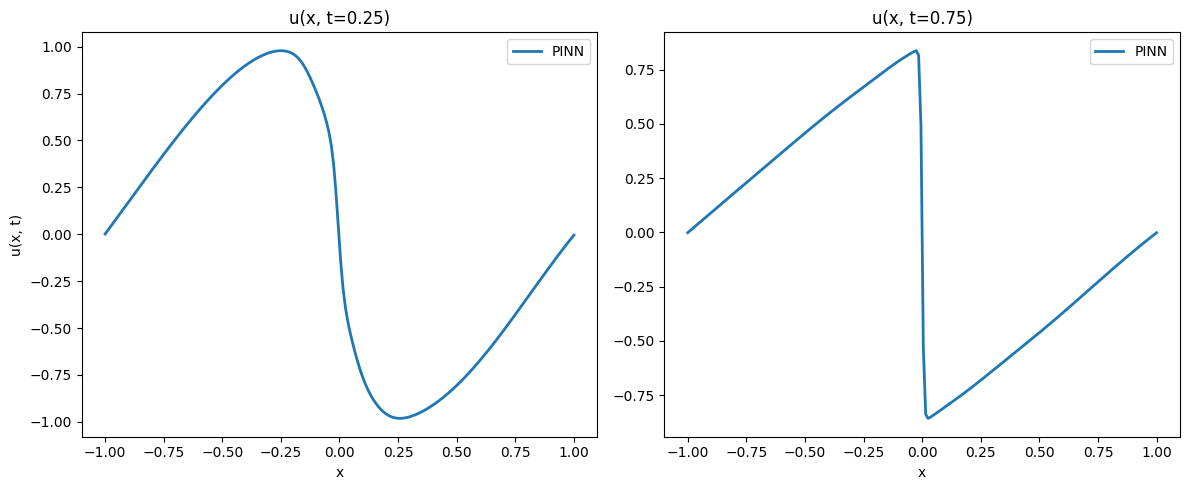

In [13]:
import matplotlib.pyplot as plt

x_vals = np.linspace(-1, 1, u_pred.shape[0])
nu = 0.01 / np.pi  # same as in your code

u_pinn_025 = u_pred[:, idx_025]
u_pinn_075 = u_pred[:, idx_075]

plt.figure(figsize=(12, 5))

# Plot at t = 0.25
plt.subplot(1, 2, 1)
plt.plot(x_vals, u_pinn_025, label='PINN', lw=2)
plt.title('u(x, t=0.25)')
plt.xlabel('x')
plt.ylabel('u(x, t)')
plt.legend()

# Plot at t = 0.75
plt.subplot(1, 2, 2)
plt.plot(x_vals, u_pinn_075, label='PINN', lw=2)
plt.title('u(x, t=0.75)')
plt.xlabel('x')
plt.legend()

plt.tight_layout()
plt.show()
